In [53]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

In [54]:
# parameter values
alpha = 1    #learning rate
beta = 0.4      #transmission rate
gamma = 0.5     #recovery rate
#discount = 0.9  #discount factor
r = 0.2         #payoff ratio
T = 0.11        #Starting Temp
N = 100         #population size
k = 4           #degree
n = 10000      #iterations

In [55]:
def boltzmann(q, T):
    q1, q2 = q[0], q[1]
    a = np.e ** (q1 / T)
    b = np.e ** (q2 / T)
    return a / (a + b)


def state(i, a_t, g):
    neighbors = np.array(g.adj[i])
    vax = np.intersect1d(np.nonzero(a_t), neighbors)
    return len(vax)

vec_state = np.vectorize(state, excluded=[1, 2])

def choose_act(i, s_t, Q, T):
    q = Q[i, s_t[i], :]
    b = boltzmann(q, T)
    p = np.random.random()
    if p < b: return 0 # do not vaccinate
    else: return 1 # vaccinate

vec_act = np.vectorize(choose_act, excluded=[1, 2, 3])

def q_update(Q, s_t, a_t, r_t1, s_t1, discount):
    for i in range(N):
        q_new = (1 - alpha) * Q[i, s_t[i], a_t[i]] + alpha * (r_t1[i] + discount * max(Q[i, s_t1[i], :]))
        Q[i, s_t[i], a_t[i]] = q_new
    return Q

def epidemic(a_t, g): 
    
    S = np.where(a_t == 0)[0]
    if len(S) == 0:
        return np.ones(N) * -r
    I = np.random.choice(S, len(S) // 10)
    S = np.setdiff1d(S, I)
    R = np.where(a_t == 1)[0]

    payoffs = np.zeros(100)
    for i in range(N):
        if np.isin(i, R):
            payoffs[i] = -r
        elif np.isin(i, I):
            payoffs[i] = -1

    I_sizes = []
    while I.shape != (0,):
        I_size = len(I)
        I_sizes.append(I_size)
        #contagion
        for i in I:
            neighbors = np.array(g.adj[i])
            S_neighbors = np.intersect1d(neighbors, S)
            p = np.random.random(len(S_neighbors))
            I_neighbors = S_neighbors[p < beta]
            I_new = np.concatenate((I, I_neighbors))
            S_new = np.setdiff1d(S, I_new)
            for i in I_neighbors: 
                payoffs[i] = -1


        #recovery
        p = np.random.random(I_size)
        R_just_recovered = I[p < gamma]
        R_new = np.concatenate((R, R_just_recovered))
        I_new = np.setdiff1d(I_new, R_new)

        S = S_new
        I = I_new
        R = R_new
    return payoffs


In [56]:
#instantiation of Q and g

g = nx.random_regular_graph(k, N)
Q = np.random.random((N, k + 1, 2))

In [57]:
def run_model(T, g, Q, discount):
    pandemic_size = np.zeros(n)
    n_vaxed = np.zeros(n)
    avg_payoff = np.zeros(n)

    a_t = np.zeros(N, dtype=int)
    p = np.random.random(N)
    a_t[p > 0.5] = 1
    s_t = vec_state(range(N), a_t, g)

    for t in tqdm(range(n)):
        r_t = epidemic(a_t, g)

        #record pandemic outcomes
        pandemic_size[t] = len(np.where(r_t == -1)[0])
        avg_payoff[t] = sum(r_t)/N
        n_vaxed[t] = sum(a_t)

        #choose next action and record next state
        a_t1 = vec_act(range(N), s_t, Q, T)
        s_t1 = vec_state(range(N), a_t1, g)

        #update q-table
        Q = q_update(Q, s_t, a_t, r_t, s_t1, discount)

        #increment t
        s_t = s_t1
        a_t = a_t1

    return avg_payoff, n_vaxed, pandemic_size



In [58]:
discounts = np.linspace(0.9, 1.0, 11)
avgs = []
for discount in discounts:
    #Q = np.random.random((N, k + 1, 2))
    avg_payoff, _, _ = run_model(T, g, Q, discount)
    avgs.append(np.mean(avg_payoff[2000:]))

Q = np.random.random((N, k + 1, 2))

discounts_flipped = np.flip(np.linspace(0.9, 1.0, 11))
avgs_flipped = []
for discount in discounts_flipped:
    #Q = np.random.random((N, k + 1, 2))
    avg_payoff, _, _ = run_model(T, g, Q, discount)
    avgs_flipped.append(np.mean(avg_payoff[2000:]))

100%|██████████| 10000/10000 [00:43<00:00, 228.64it/s]


Text(0.5, 1.0, 'T = 0.11')

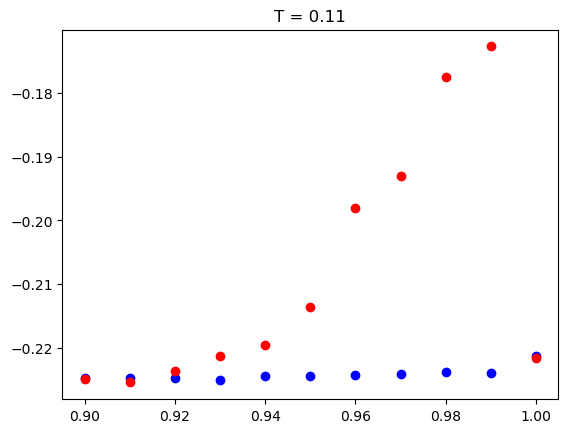

In [59]:
plt.plot(discounts, avgs, 'o', color='b')
plt.plot(discounts_flipped, avgs_flipped, 'o', color='r')
plt.title(f'T = {T}')

In [60]:
print(avgs_flipped[0])
print(avgs[-3])

-0.22151349999999986
-0.22370724999999983


In [61]:
discountsT = discounts
discountsT_flipped = discounts_flipped